<a href="https://colab.research.google.com/github/SomValentino/Convolutional_Neutral_Network/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix



In [2]:
# get traing sets
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transforms.ToTensor())

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 195MB/s]


Extracting /cnn_data/MNIST/raw/train-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 38.2MB/s]

Extracting /cnn_data/MNIST/raw/train-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 95.4MB/s]


Extracting /cnn_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /cnn_data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.45MB/s]

Extracting /cnn_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /cnn_data/MNIST/raw



In [3]:
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transforms.ToTensor())

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [6]:
# define the CNN layer
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

In [7]:
conv1 = nn.Conv2d(1, 6, 3, 1)

conv2 = nn.Conv2d(6, 16, 3, 1)

In [8]:
for i, (X_train, y_train) in enumerate(train_loader):
    print(i, X_train.shape, y_train.shape)
    break

0 torch.Size([10, 1, 28, 28]) torch.Size([10])


In [9]:
x = F.elu(conv1(X_train))

x.shape

torch.Size([10, 6, 26, 26])

In [10]:
x = F.max_pool2d(x, 2, 2)

x.shape

torch.Size([10, 6, 13, 13])

In [11]:
x = F.elu(conv2(x))

x.shape

torch.Size([10, 16, 11, 11])

In [12]:
x = F.max_pool2d(x, 2, 2)

x.shape

torch.Size([10, 16, 5, 5])

In [13]:
# define the CNN layer
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.featureExtractor = nn.Sequential(
            nn.Conv2d(1, 6, 3, 1),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3, 1),
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten()
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ELU(),
            nn.Linear(120, 84),
            nn.ELU(),
            nn.Linear(84, 10),
            nn.LogSoftmax(dim=1)
        )
    def forward(self, x):
      x = self.featureExtractor(x)
      x = self.classifier(x)
      return x

In [14]:
# Create an instance of the model
torch.manual_seed(41)
model = CNN()
model

CNN(
  (featureExtractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ELU(alpha=1.0)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ELU(alpha=1.0)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=84, out_features=10, bias=True)
    (5): LogSoftmax(dim=1)
  )
)

In [15]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
import time

start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0

    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1

        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)



        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b % 600 == 0:
            print(y_pred.data)
            print(torch.max(y_pred.data, 1))
            print(predicted)
            print(predicted == y_train)
            print(f'epoch: {i}  batch: {b} loss: {loss.item()}')

    train_losses.append(loss)

    train_correct.append(trn_corr)

    # Tests
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test)
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)



current_time = time.time()

total = current_time - start_time

print(f'Training Took: {total/60} minutes')

tensor([[-1.3304e+01, -3.1198e-03, -8.2970e+00, -9.3536e+00, -8.5516e+00,
         -1.0979e+01, -6.8236e+00, -7.8397e+00, -7.1944e+00, -8.0021e+00],
        [-1.1264e+01, -7.8214e+00, -4.0460e-03, -5.8333e+00, -1.3001e+01,
         -1.3236e+01, -9.1088e+00, -1.2859e+01, -7.4646e+00, -1.2143e+01],
        [-9.1143e+00, -1.2982e+01, -8.7162e+00, -4.0602e+00, -1.0446e+01,
         -1.3374e-01, -9.1604e+00, -1.4475e+01, -2.2435e+00, -6.5408e+00],
        [-8.2649e-04, -1.6010e+01, -7.8094e+00, -1.2345e+01, -9.3622e+00,
         -1.2727e+01, -1.1240e+01, -8.5910e+00, -1.2049e+01, -9.0097e+00],
        [-9.8100e+00, -9.5282e+00, -8.7218e+00, -3.6352e+00, -1.2043e+01,
         -2.8485e-01, -1.0207e+01, -1.2152e+01, -1.5163e+00, -6.4113e+00],
        [-1.3210e+01, -1.5329e+01, -1.3576e+01, -1.6074e+01, -1.5826e-02,
         -1.4576e+01, -1.2051e+01, -9.0461e+00, -9.1246e+00, -4.1692e+00],
        [-5.0656e+00, -1.3897e+01, -7.5877e-03, -7.3707e+00, -8.7793e+00,
         -1.1090e+01, -1.1101e+0

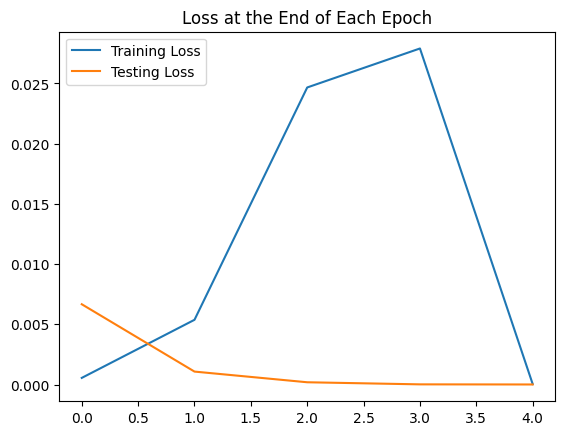

In [17]:
# Graph the loss at each epoch
train_losses = [t1.item() for t1 in train_losses]
test_losses = [t1.item() for t1 in test_losses]
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the End of Each Epoch')
plt.legend()

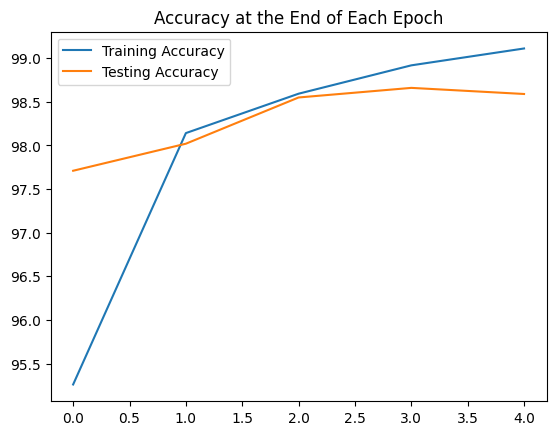

In [18]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the End of Each Epoch')
plt.legend()
plt.show()

In [19]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [20]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()
    print(f'Test Accuracy: {correct.item()/10000}')

Test Accuracy: 0.9859


In [21]:
test_data[4143]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [28]:
with torch.no_grad():
    y_val = model(test_data[4143][0].view(1, 1, 28, 28))
    print(torch.max(y_val, 1)[1].item())

9


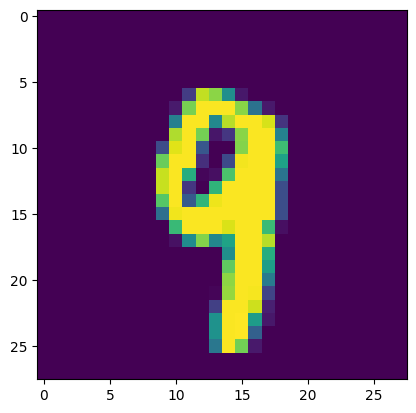

In [27]:
plt.imshow(test_data[4143][0].reshape(28, 28))

In [29]:
with torch.no_grad():
    y_val = model(test_data[1978][0].view(1, 1, 28, 28))
    print(torch.max(y_val, 1)[1].item())

4


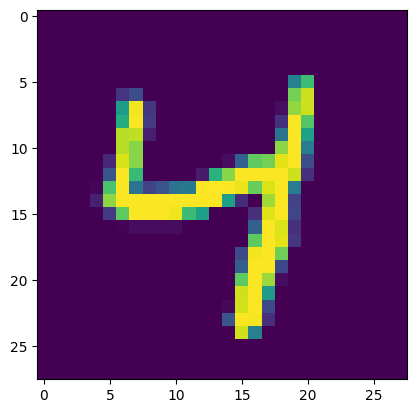

In [30]:
plt.imshow(test_data[1978][0].reshape(28, 28))